# Visualisations Topic Prevalences

In [80]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
%matplotlib inline

# save location of data
datafolder = "/home/hennes/thesis/Data/"
# save location of figures
figureloc = "/home/hennes/thesis/Figures/topics/"

# create uniform colour palette
palette ={"Radio Corporacion": "#dd8452","Canal14": "#4c72b0","Canal10": "#da8bc3",
          "regime": "#c44e52", "opposition": "#55a868"}
# set uniform figure size
sns.set(rc={'figure.figsize':(20,10)})
# set seaborne style
sns.set_theme(style = 'whitegrid', font_scale=1.8)

## Preparation of Data for Visualisation

In [86]:
# load data
df = pd.read_csv(datafolder+"topic_prevalences.csv")

# drop Radio 800
df = df.loc[df["page"] != "Radio 800"]

# transform date to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# keep only data from 2017
df = df.loc[df["date"] > "2016"]

repl_dict = {
    "Canal10":"Canal10",
     'Canal4':"regime",
     'Radio la Primerisima':"regime",
     'Confidencial':"opposition",
     'Canal6':"regime",
     'Canal14':"Canal14",
     '100% Noticias':"opposition",
     'Canal13':"regime",
     'Canal2':"regime", 
     'Radio Nicaragua':"regime",
     'Radio Corporacion':"Radio Corporacion"
}

# create categories
df["position"] = df["page"].replace(repl_dict)

# create different date periods for aggregation
df["quarter"] = df.date.dt.to_period('Q')
df['quarter'] = df['quarter'].apply(lambda x: x.strftime('%Y-%m'))

df["semiannual"] = df.date.dt.to_period('2Q')
quarts = [["2022Q2", "2022Q1"],
["2021Q2", "2021Q1"],
["2021Q4", "2021Q3"],
["2020Q2", "2020Q1"],
["2020Q4", "2020Q3"],
["2019Q2", "2019Q1"],
["2019Q4", "2019Q3"],
["2018Q2", "2018Q1"],
["2018Q4", "2018Q3"],
["2017Q2", "2017Q1"],
["2017Q4", "2017Q3"],
["2016Q2", "2016Q1"],
["2016Q4", "2016Q3"],]

for pair in quarts:
    df.loc[df["semiannual"] == pair[0], "semiannual"] = pair[1]

df['semiannual'] = df['semiannual'].apply(lambda x: x.strftime('%Y-%m'))
    
df["year"] = df.date.dt.to_period('Y')
df['year'] = df['year'].apply(lambda x: x.strftime('%Y'))
df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))

df.days = df["date"].apply(lambda x: (x.to_pydatetime() - datetime.datetime(2016,1,2)).days)

# these are the topics identified as being relevant to regime legitimation
relevant_cols = ['1 Corona Cases',
 "11 Business, Public Projects",
 '12 Legal Cases (against opposition)',
 '13 Police, Detentions, Protests',
 "16 Municipalities",
 '17 Elections, Parties',
 '19 Welfare, State-Citizen Interactions',
 '21 Press and Censorship',
 '24 Human Rights, Protests',
 '27 Conflict with OAS']

## Create Polynomial Plots for Topic Prevalences of relevant Topics

In [82]:
# set x-axis ticks
ticks = [730, 912, 1095, 1277, 1460, 1643, 1826, 2008, 2191]
dates = [df.loc[df["days"] == x, "date"].min().to_pydatetime().strftime("%Y-%m") for x in ticks]

# find days representation for vertical lines
def find_day(date):
    return df.loc[df["date"] == date, "days"].min()

events = [[find_day("2018-04-18"), "beginning of\nprotests"],
         [find_day("2020-10-26"), "passing of\ncybercrime law"],
         [find_day("2021-06-20"), "series of journalist\njailings and raids\non newsrooms"],
         [find_day("2018-12-15"), "occupation of\noffices of Confidencial\nand 100% Noticias"],
         [find_day("2019-09-27"), "closure of\nnational newspaper\nEl Nuevo Diario"]]

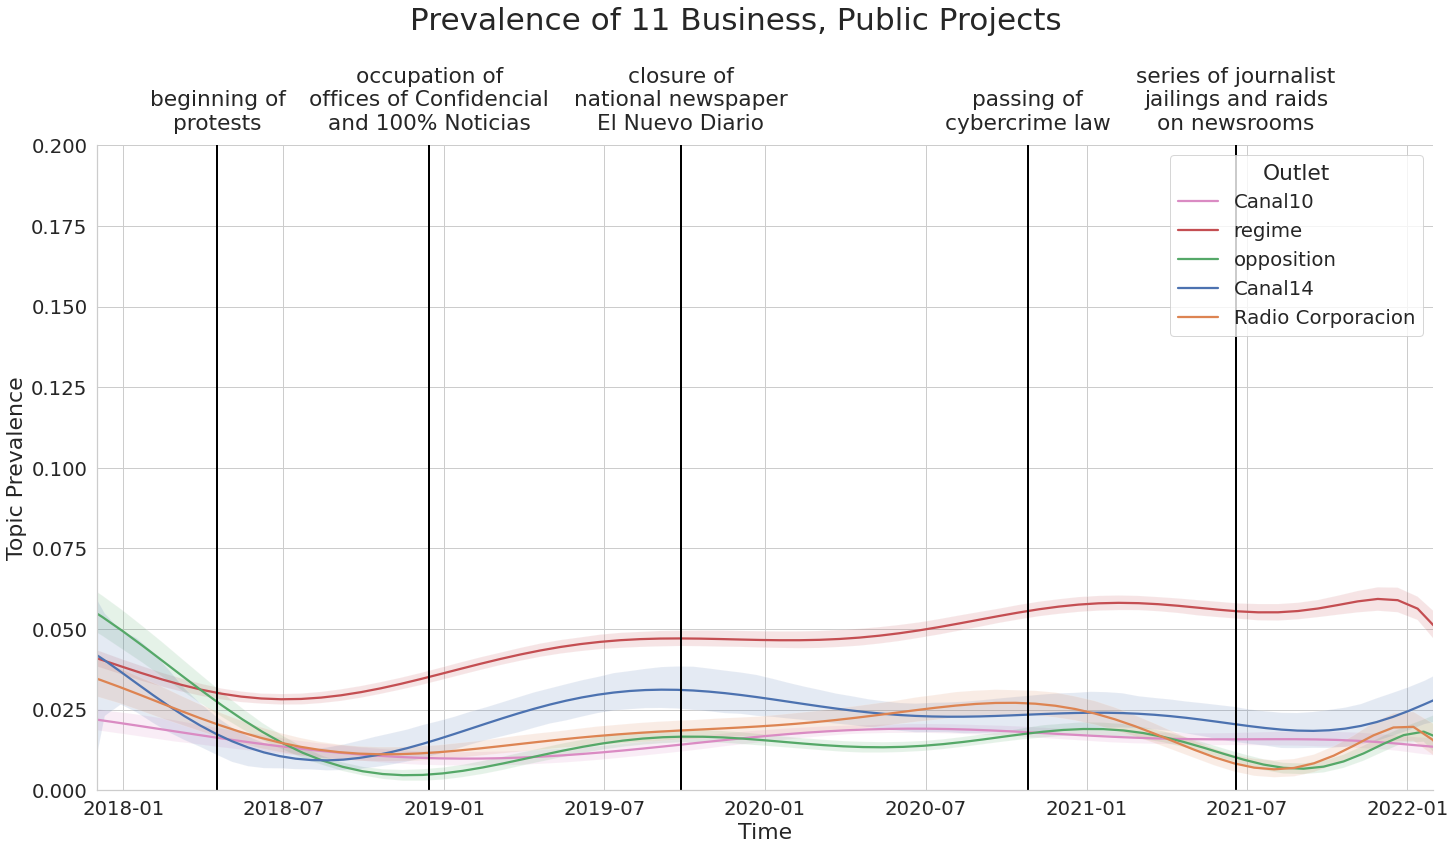

In [87]:
# loop through these topics and create polynomial plots for them
for col in relevant_cols[1:2]:
    data = df
    figure = sns.lmplot(data = data, x= "days", order = 11,
               y= col, hue = "position", palette = palette,
              scatter = False, height=10, aspect= 2, legend = False)
    # control x and y limits
    plt.ylim(0, 0.2)
    plt.xlim(700, 2220)
    
    # set ticks
    for ax in figure.axes.flat:
        # set ticks on x axis
        ax.set_xticks(ticks)
        # label the ticks
        ax.set_xticklabels(dates)
    
    # set axis names
    plt.xlabel("Time", fontsize = 22)
    plt.ylabel("Topic Prevalence", fontsize = 22)
    plt.legend(title = "Outlet")      
    
    # leave some space on top of plot for title
    figure.set(xlabel = "Time", ylabel = f"Topic Prevalence")
    plt.suptitle(t = f'Prevalence of {col}', ha = "center", y = 1.16,
                size = "x-large")

    # place annotated lines for regime measures
    for x in range(len(events)):
        plt.axvline(events[x][0], ymax = 1, linewidth=2, color = "black")
        plt.annotate(events[x][1], xy=(events[x][0],0.205), ha='center', annotation_clip=False)
    
    # save plot
    plt.savefig(figureloc+f'{col}.png', bbox_inches="tight")

## Create independence score

### Create Aggregated df for Visualisation

In [77]:
# set seaborne style
sns.set_theme(style = 'whitegrid', font_scale=1.5)

# Can change level of aggregation by specifying different replacements for df.date
df = df.loc[df["date"] > "2017-12-31"]
agg_level = "quarter"
df["date"] = df[agg_level]
df["date"] = pd.to_datetime(df["date"])

if agg_level == "quarter":
    # uncomment this line if semiannual is chosen. First half of 2018 still not useful for topic independence
    df = df.loc[df["date"] != "2018-03"]

df_agg = (df
          .groupby(["position", "date"])
          .agg("mean")
          .reset_index())

# events to mark on plot
events = [[pd.to_datetime("2020-10-26"), "passing of\ncybercrime law"],
         [pd.to_datetime("2021-06-20"), "series of journalist\njailings and raids\non newsrooms"],
         [pd.to_datetime("2018-12-15"), "occupation of\noffices of Confidencial\nand 100% Noticias"],
         [pd.to_datetime("2019-09-27"), "closure of\nnational newspaper\nEl Nuevo Diario"]]

### Independence Scores without weights or NANs

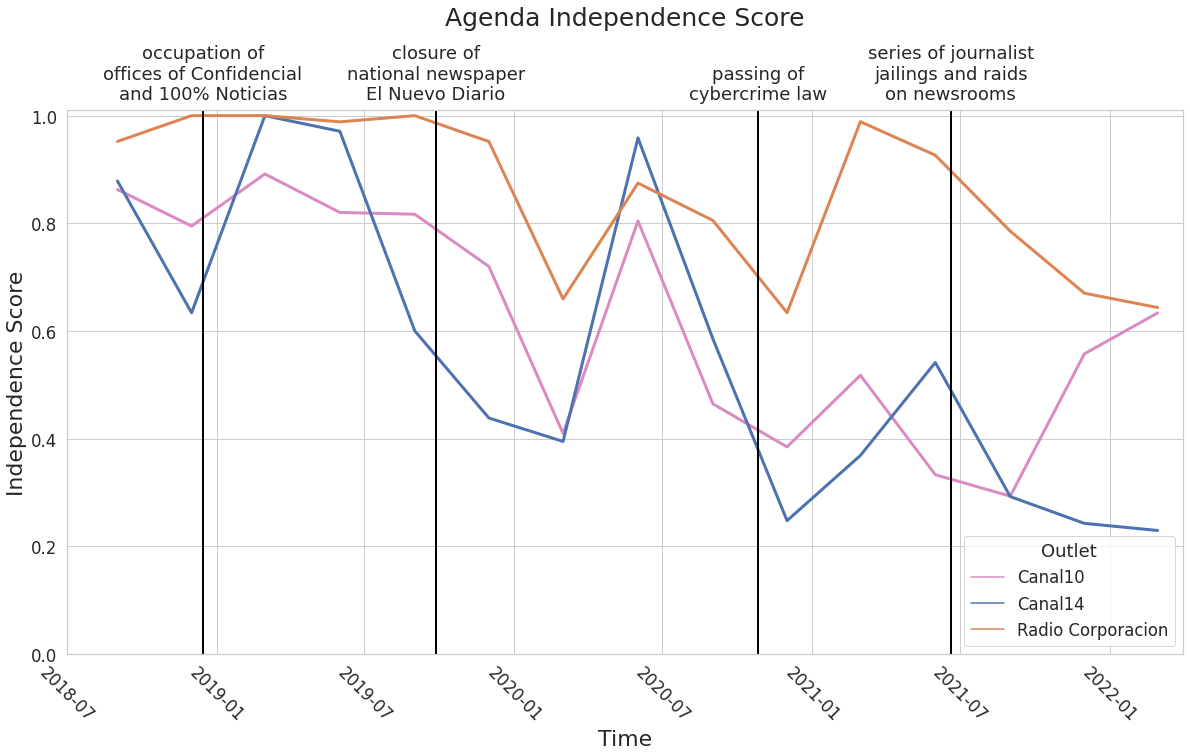

In [78]:
##################################################
# Choose option for independence score calculation

# "no weights", "NAN", or "weights" 
option = "weights"
##################################################

# create separate wide df for each topic
topic_dfs = {}
for x in relevant_cols:
    dfx = pd.pivot(df_agg,
                   index = "date",
                   columns = "position",
                   values = x)
# calculate independence score for in each df
    dfx["canal10_ind"] = ((dfx["Canal10"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["canal14_ind"] = ((dfx["Canal14"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["Radio Corporacion_ind"] = ((dfx["Radio Corporacion"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)

    if option == "no weights":
        None
    elif option == "NAN":
        
        # make independence scores NA if there is no substantive difference between regime and opposition
        # the idea is that independence can only exist if topic is relevant at the time to regime legitimation
        # e.g. corona did not exist in 2018, so difference in the topic in that year should not factor into the
        # calculation of the independence of an outlet for that year
        dfx["canal10_ind"] = (dfx["canal10_ind"]
                              .where(((dfx["regime"]-dfx["opposition"])**2)**0.5 > 0.015, np.nan))
        dfx["canal14_ind"] = (dfx["canal14_ind"]
                              .where(((dfx["regime"]-dfx["opposition"])**2)**0.5 > 0.015 , np.nan))
        dfx["Radio Corporacion_ind"] = (dfx["Radio Corporacion_ind"]
                                        .where(((dfx["regime"]-dfx["opposition"])**2)**0.5 > 0.015 , np.nan))
        
    elif option == "weights":
        
        # create weight variable, so that it is 1 when there is a .1 difference in topic prevalence between regime
        # and opposition. That is about as distant as it gets.
        dfx["weight"] = ((dfx["regime"]-dfx["opposition"])**2)**0.5
        dfx["weight"].where(dfx["weight"] > 0.013 , np.nan, inplace = True)
        dfx["weight"] = dfx["weight"]*20

        # applying weights to independence scores
        dfx["canal10_ind"] = dfx["canal10_ind"]*dfx["weight"]
        dfx["canal14_ind"] = dfx["canal14_ind"]*dfx["weight"]
        dfx["Radio Corporacion_ind"] = dfx["Radio Corporacion_ind"]*dfx["weight"]
        
# save in dictionary
    topic_dfs.update({x:dfx})

# put independence scores per topic back into one long-format df

df_ind = df_agg[df_agg["position"].isin(["Canal10", "Canal14", "Radio Corporacion"])][["position", "date"]]

for x in relevant_cols:
    df_ind[x] = pd.melt(topic_dfs[x].reset_index(),
                        id_vars=['date'],
                        value_vars=['canal10_ind', "canal14_ind", "Radio Corporacion_ind"],
                        value_name = "independence score")["independence score"]
# bring into long format
df_ind = pd.melt(df_ind,
        id_vars=["position", 'date'],
        value_vars=relevant_cols,
        value_name = "independence score",
        var_name = "topic")

# aggregate per outlet
df_final = df_ind.groupby(["position", "date"]).agg("mean").reset_index()

df_final["independence score"].clip(0, 1, inplace = True)

#df_final.date = df_final["date"].apply(lambda x: (pd.Period.to_timestamp(x) - datetime.datetime(2017,1,1)).days)

sns.lineplot(data = df_final, x="date", y="independence score", hue="position",
             palette=palette, linewidth = 3)

# add event lines and annotations
for x in range(len(events)):
    plt.axvline(events[x][0], ymax = 1, linewidth=2, color = "black")
    plt.annotate(events[x][1], xy=(events[x][0], 1.03), ha='center', annotation_clip=False)


# set plot title
plt.title("Agenda Independence Score", fontsize = 25, pad = 85)
# rotate x-ticks by 315 degrees
plt.xticks(rotation=315)
# set x axis limits
plt.xlim(pd.to_datetime("2018-07-01"), pd.to_datetime("2022-04-01"))
# set y axis limits
plt.ylim(0, 1.01)
# set axis names
plt.xlabel("Time", fontsize = 22)
plt.ylabel("Independence Score", fontsize = 22)
plt.legend(title = "Outlet")
# save figure
plt.savefig(figureloc+f'agenda_{agg_level}.png', bbox_inches="tight")

### Create Polynomial Plot of Independence Score

/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs)

/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs)

/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hennes/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs)

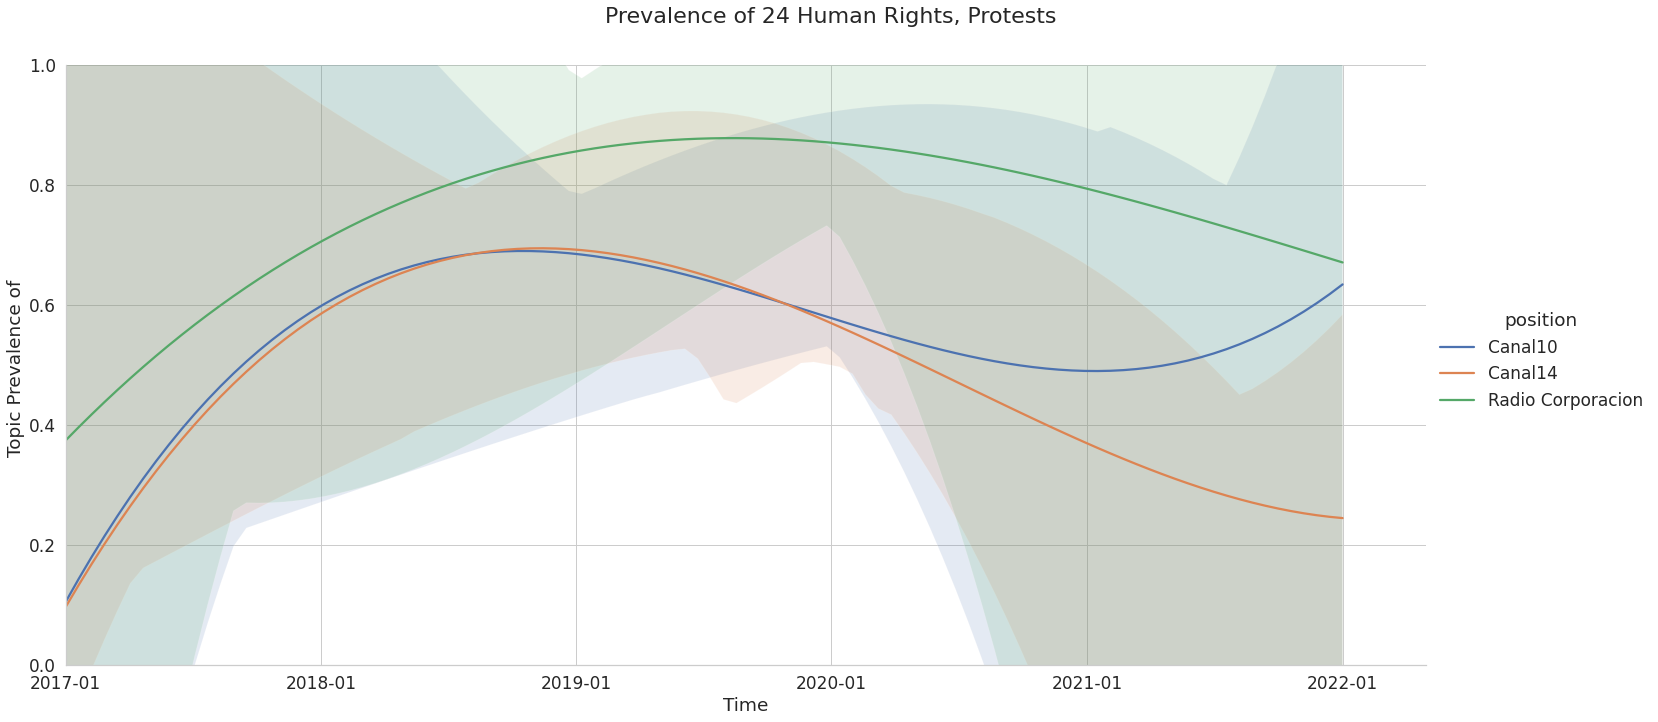

In [53]:
# set seaborne style
sns.set_theme(style = 'whitegrid', font_scale=1.54)

# convert date from string to datetime variable
df_final["date"] = pd.to_datetime(df_final["date"])

# create float representation of date
df_final["days"] = df_final["date"].apply(lambda x: (x.to_pydatetime() - datetime.datetime(2017,1,1)).days)

ticks = [0, 365, 730, 1095, 1461, 1826]
dates = [df_final.loc[df_final["days"] == x, "date"].min().to_pydatetime().strftime("%Y-%m") for x in ticks]

data = df_final
figure = sns.lmplot(data = data, x= "days", order = 3,
           y= "independence score", hue = "position",
          scatter = False, height=10, aspect= 2)
# control x and y limits
plt.ylim(0, 1)
plt.xlim(0, 1946)

for ax in figure.axes.flat:
    ax.set_xticks(ticks)
    ax.set_xticklabels(dates)
    
figure.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
figure.fig.suptitle('Prevalence of 24 Human Rights, Protests')
figure.set(xlabel = "Time", ylabel = f"Topic Prevalence of ")

plt.show()